## Семинар 6 "Segmentation"

ФИО: Токаева Александра Александровна

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 ноября 2021). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms as tsf
import scipy.misc
import torch.nn as nn
from pathlib import Path
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.nn import MSELoss
import torch

from PIL import Image
import skimage
from skimage import io

from torch.utils.tensorboard import SummaryWriter

TRAIN_PATH = './train.pth'
TEST_PATH = './test.pth'
%matplotlib inline

In [2]:
def process(dataset_path, mask_path=None, filter_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)
        
    if filter_path:
        filter_path = Path(filter_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
            
        if filter_path:
            filter_elem = io.imread(filter_path/(item['name'] + '_training_mask.gif'))
            item['filter'] = t.from_numpy(filter_elem)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('train/images', "train/1st_manual/", 'train/mask/')

/Users/aleksandra/anaconda3/lib/python3.7/site-packages/imageio/plugins/_tifffile.py:8388: UserWarning: unexpected end of LZW stream (code 0)
  warnings.warn('unexpected end of LZW stream (code %i)' % code)


In [3]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform, filter_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
        self.f_transform = filter_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        filt = data['filter'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        filt = self.f_transform(filt)
        return img, mask, filt
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
f_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128, 128)),
    tsf.ToTensor()
])
train_dataset = Dataset(train_data,s_trans,t_trans,f_trans)
#dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

torch.Size([3, 128, 128])
torch.Size([1, 128, 128])


/Users/aleksandra/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [4]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

test_dataset = TestDataset(TEST_PATH, s_trans)
#testdataloader = t.utils.data.DataLoader(test_dataset,batch_size=1)

In [5]:
testdataloader = t.utils.data.DataLoader(test_dataset,batch_size=1)

In [6]:
test_dataset[0].shape

torch.Size([3, 128, 128])

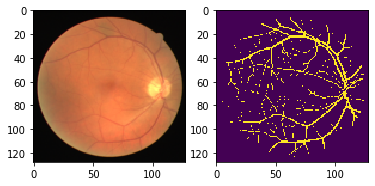

In [7]:
img,mask,filt = train_dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [8]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch) 

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes=0):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = F.sigmoid(x)
        return x

torch.Size([1, 128, 128])


/Users/aleksandra/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


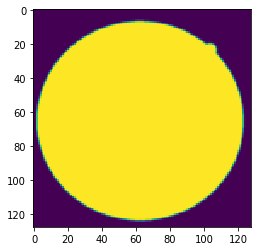

In [9]:
from torchvision import transforms
from PIL import Image
p = transforms.Compose([transforms.Scale((128, 128)), tsf.ToTensor()])
m=p(Image.open("train/mask/21_training_mask.gif"))
print(m.shape)
plt.imshow(m[0])

In [10]:
# Попробуйте использовать различные функции потерь.
#from torchvision import transforms
#from PIL import Image
#p = transforms.Compose([transforms.Scale((128, 128)), tsf.ToTensor()])
#m=p(Image.open("train/mask/21_training_mask.gif"))
#m=m[0]

def soft_dice_loss(inputs, targets, filters):
    m1 = inputs * filters
    m2 = targets * filters
    intersection = (m1 * m2)
    score = (2. * intersection.sum() + 1) / (m1.sum() + m2.sum() + 1)
    return 1 - score

In [11]:
def train(network, epochs, learning_rate):
    loss = soft_dice_loss
    #loss=MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y, f in train_dataset:
                X=X.reshape(-1,3,128,128)
                network.zero_grad()
                prediction = network(X)
                y=y[0]
                prediction=prediction[0][0]
                #print(y.shape) 
                #print(prediction.shape)
                loss_batch = loss(prediction, y, f[0])
                #print("train_loss=",loss_batch)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                #accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            #train_accuracy_epochs.append(np.mean(accuracies))
            
            
            print('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], train_loss_epochs[-1]))
            
            
            plt.figure(figsize=(12, 5))
            #plt.subplot(1, 1, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

/Users/aleksandra/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0... (Train/Test) MSE: 0.649/0.649


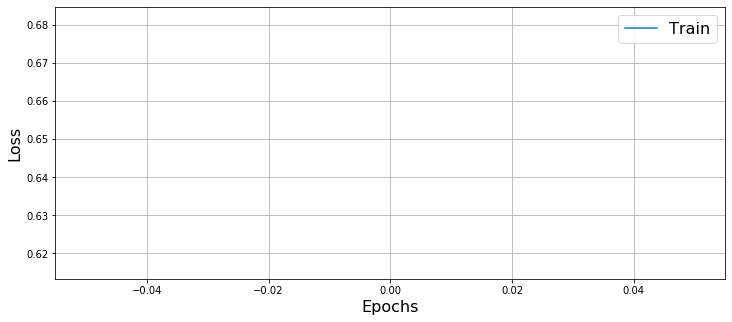

Epoch 1... (Train/Test) MSE: 0.499/0.499


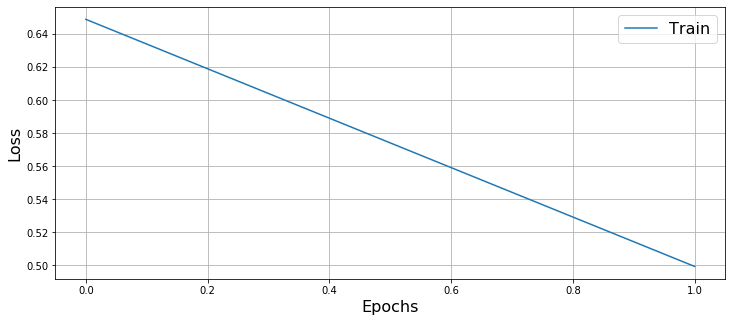

Epoch 2... (Train/Test) MSE: 0.412/0.412


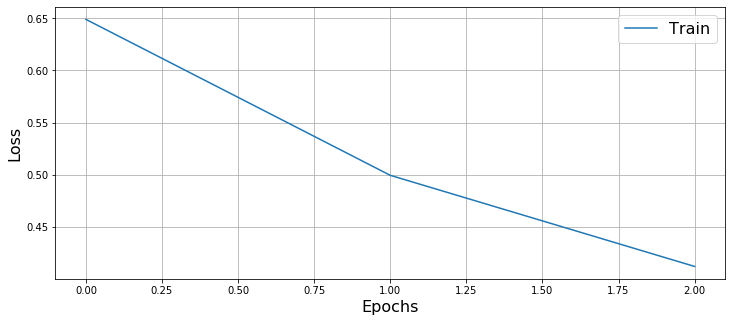

Epoch 3... (Train/Test) MSE: 0.359/0.359


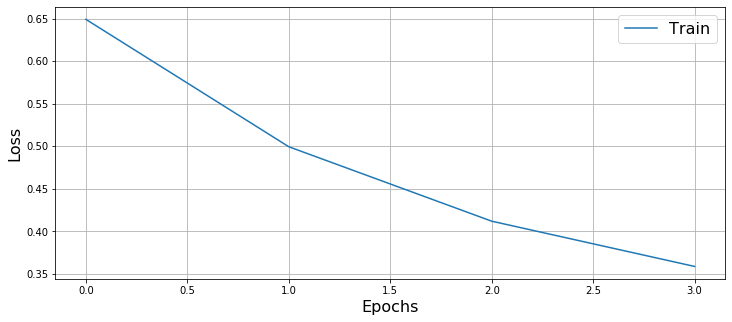

Epoch 4... (Train/Test) MSE: 0.327/0.327


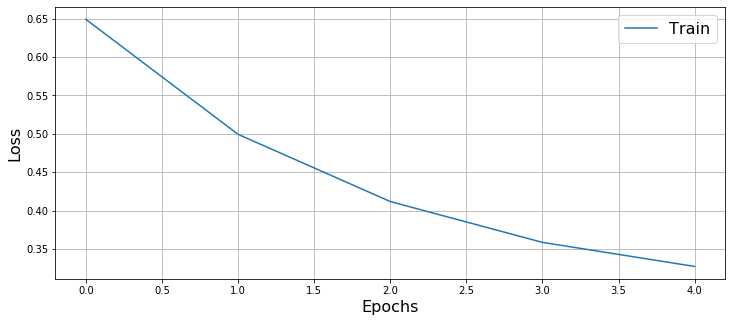

Epoch 5... (Train/Test) MSE: 0.316/0.316


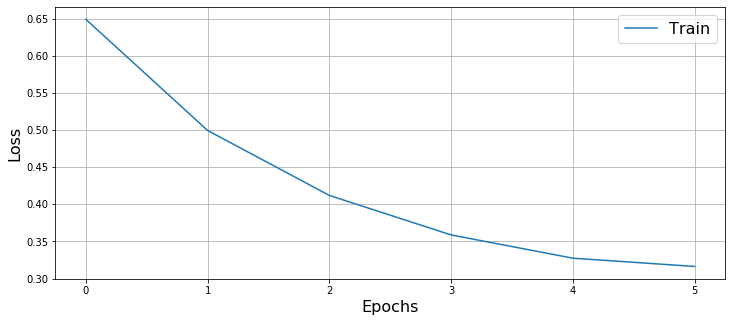

Epoch 6... (Train/Test) MSE: 0.307/0.307


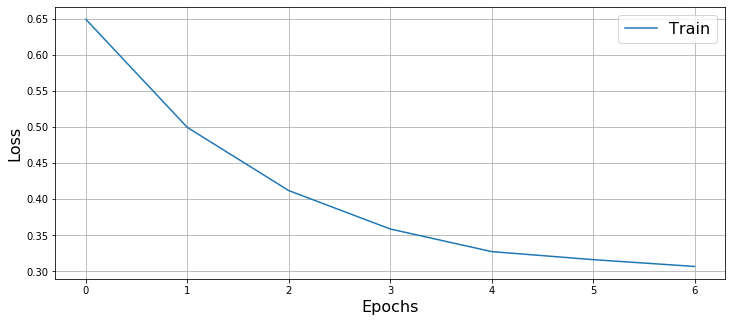

Epoch 7... (Train/Test) MSE: 0.299/0.299


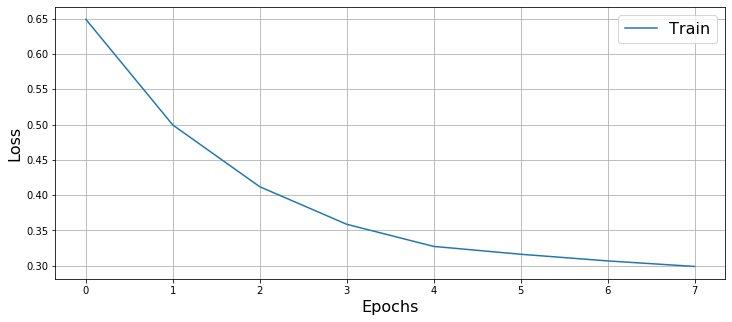

Epoch 8... (Train/Test) MSE: 0.289/0.289


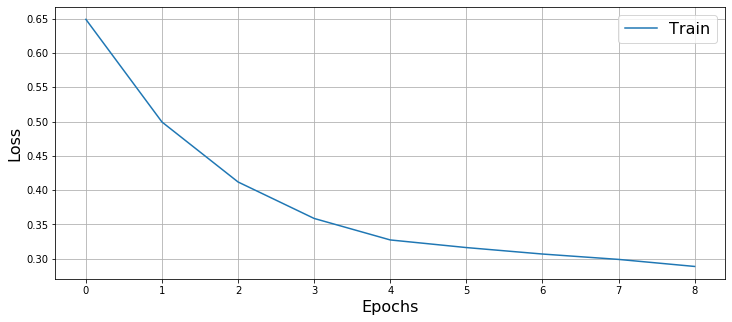

Epoch 9... (Train/Test) MSE: 0.283/0.283


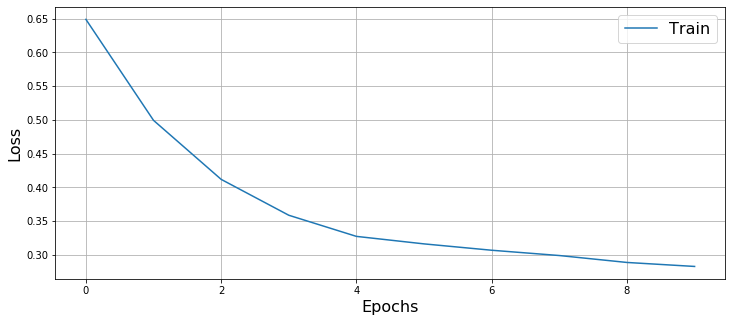

Epoch 10... (Train/Test) MSE: 0.280/0.280


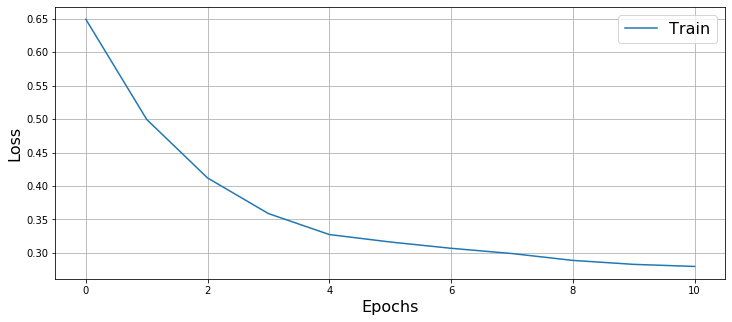

Epoch 11... (Train/Test) MSE: 0.275/0.275


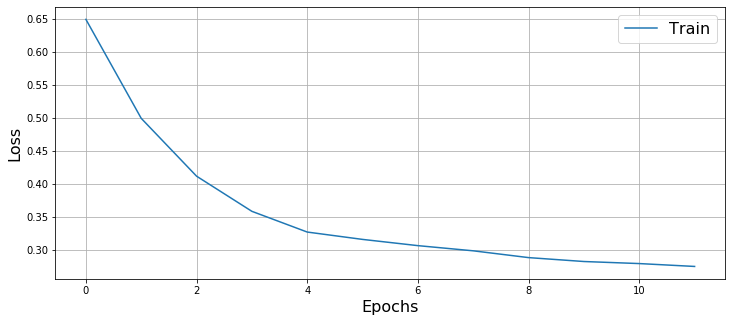

Epoch 12... (Train/Test) MSE: 0.271/0.271


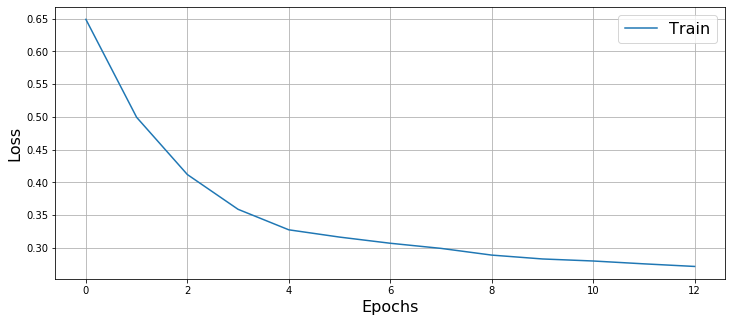

Epoch 13... (Train/Test) MSE: 0.264/0.264


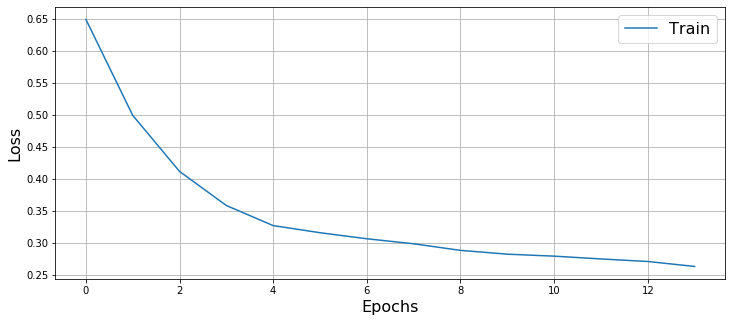

Epoch 14... (Train/Test) MSE: 0.255/0.255


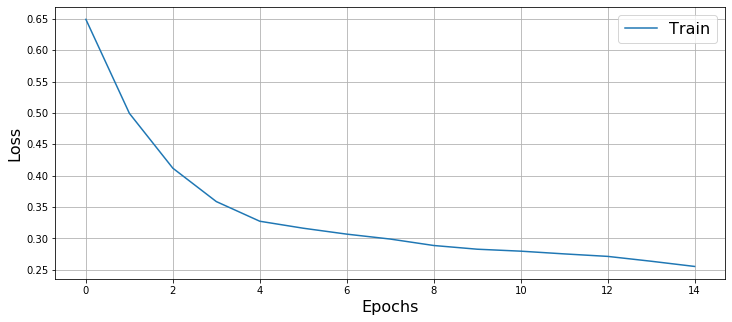

Epoch 15... (Train/Test) MSE: 0.251/0.251


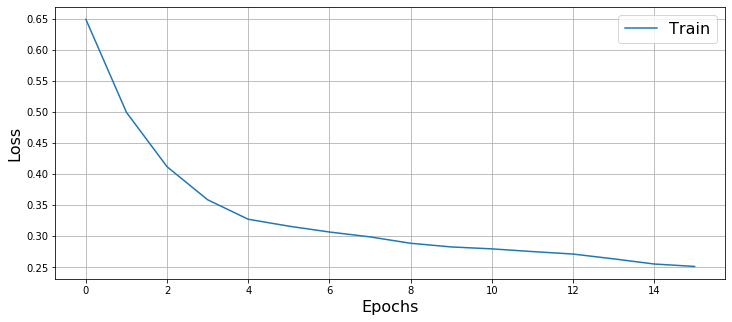

Epoch 16... (Train/Test) MSE: 0.249/0.249


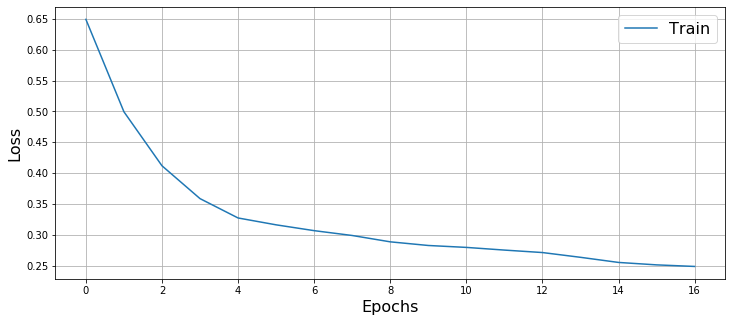

Epoch 17... (Train/Test) MSE: 0.250/0.250


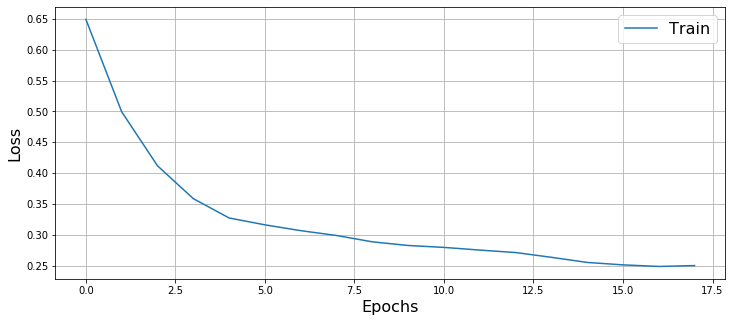

Epoch 18... (Train/Test) MSE: 0.253/0.253


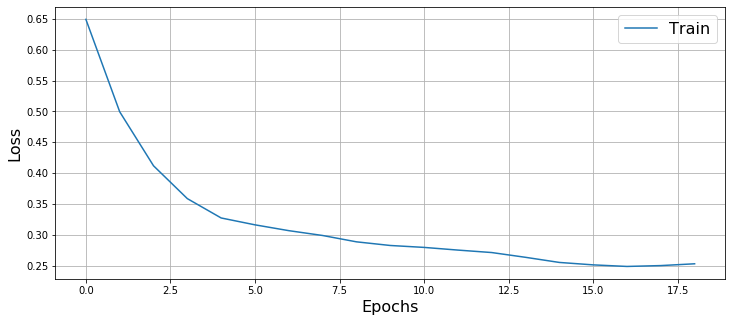

Epoch 19... (Train/Test) MSE: 0.245/0.245


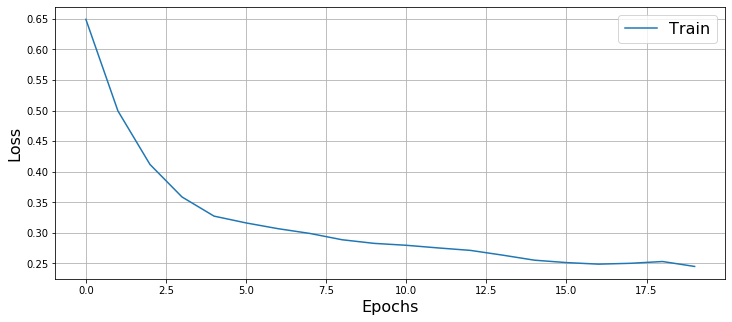

Epoch 20... (Train/Test) MSE: 0.236/0.236


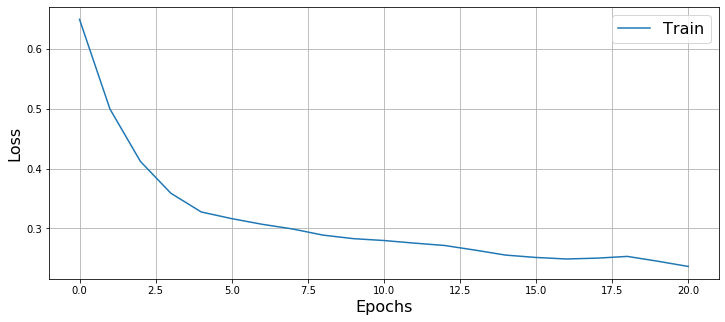

Epoch 21... (Train/Test) MSE: 0.228/0.228


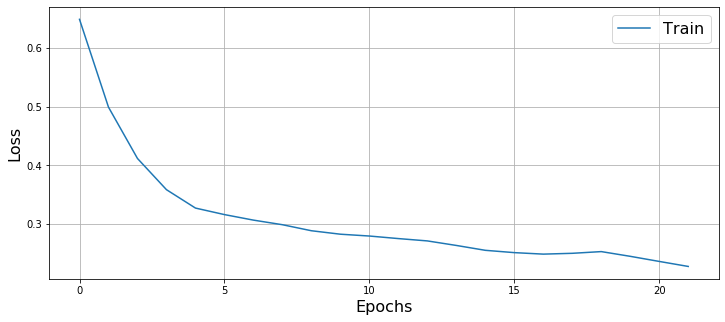

Epoch 22... (Train/Test) MSE: 0.225/0.225


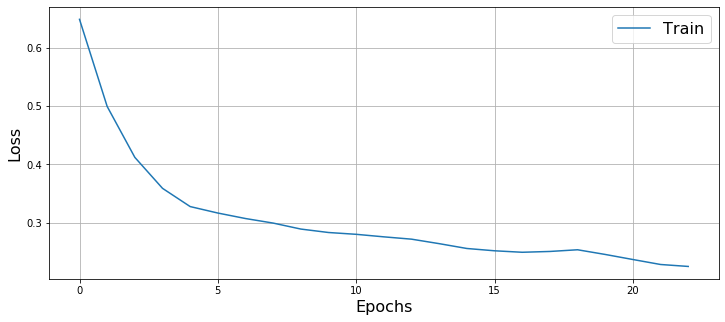

Epoch 23... (Train/Test) MSE: 0.227/0.227


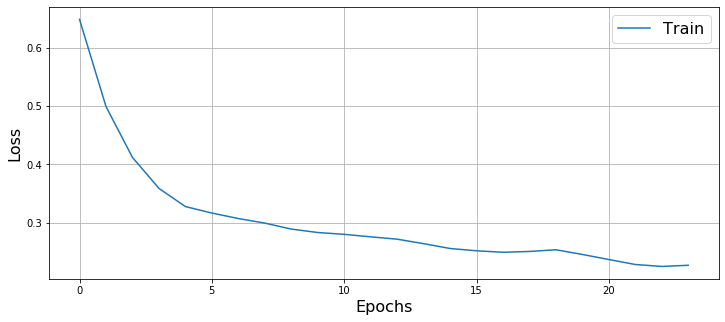

Epoch 24... (Train/Test) MSE: 0.230/0.230


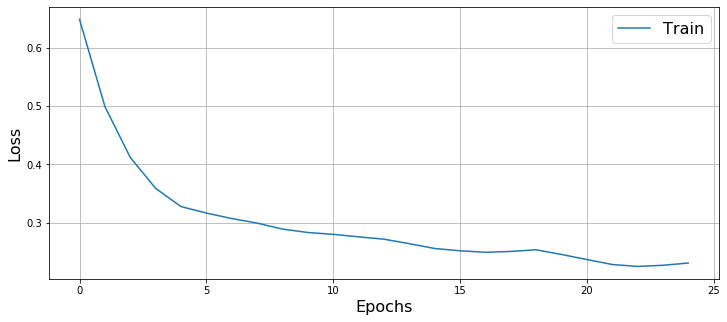

Epoch 25... (Train/Test) MSE: 0.233/0.233


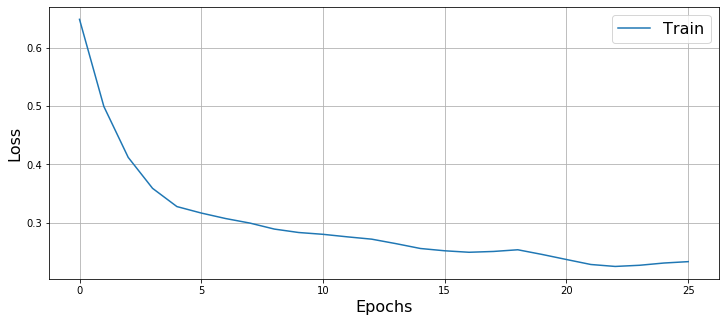

Epoch 26... (Train/Test) MSE: 0.222/0.222


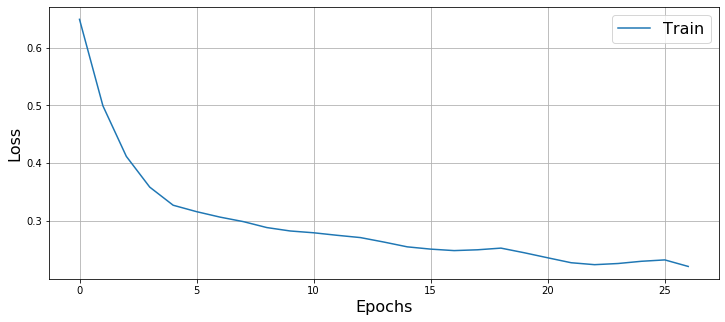

Epoch 27... (Train/Test) MSE: 0.214/0.214


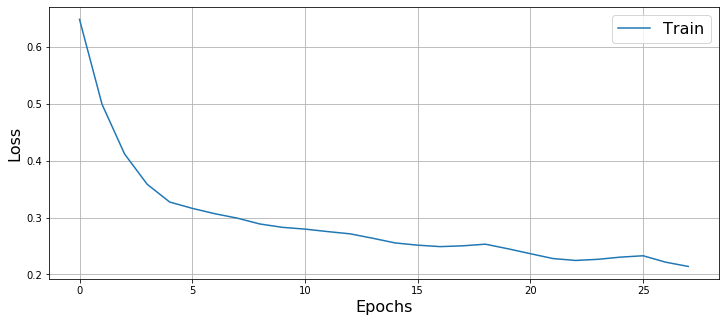

Epoch 28... (Train/Test) MSE: 0.212/0.212


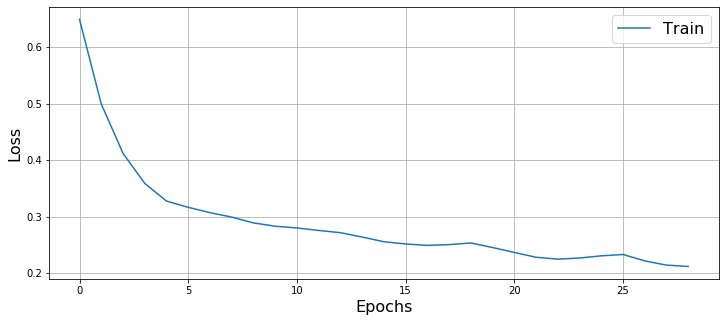

Epoch 29... (Train/Test) MSE: 0.209/0.209


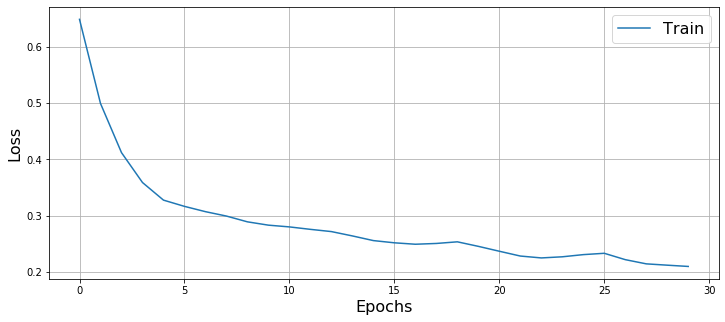

Epoch 30... (Train/Test) MSE: 0.203/0.203


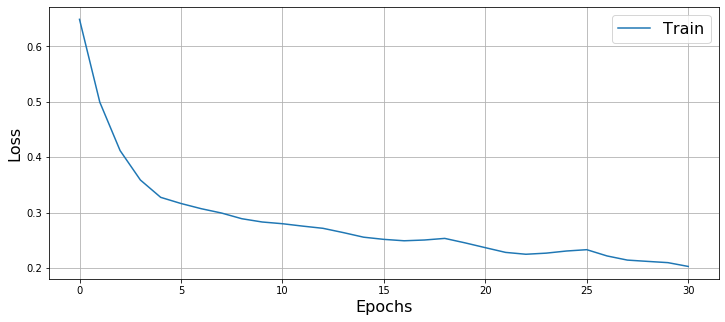

Epoch 31... (Train/Test) MSE: 0.194/0.194


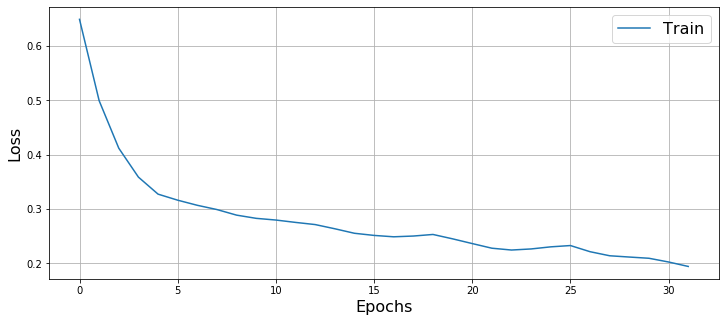

Epoch 32... (Train/Test) MSE: 0.190/0.190


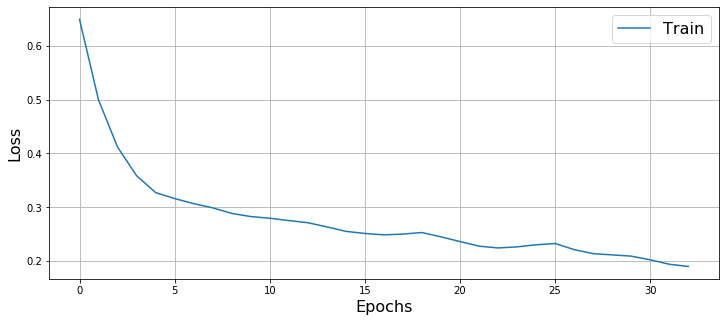

Epoch 33... (Train/Test) MSE: 0.190/0.190


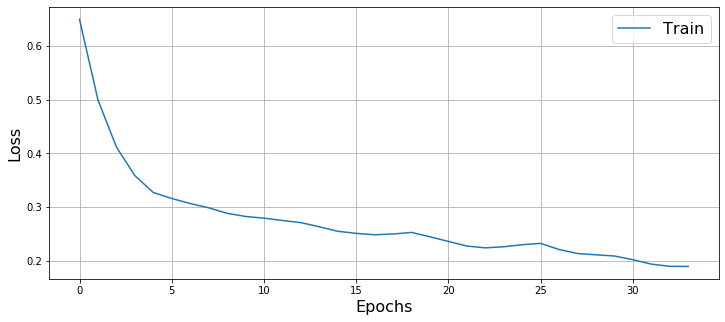

Epoch 34... (Train/Test) MSE: 0.193/0.193


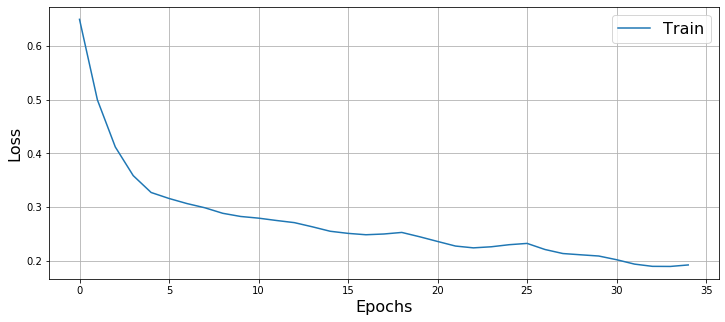

Epoch 35... (Train/Test) MSE: 0.195/0.195


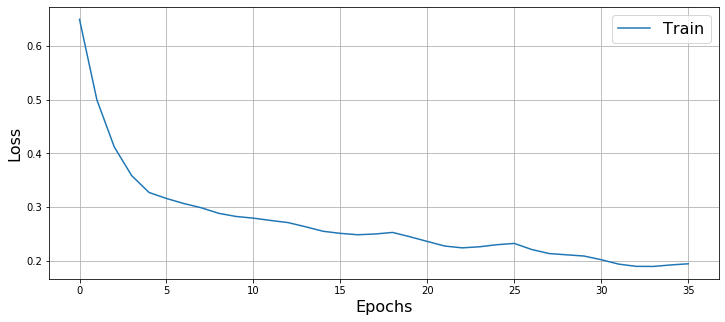

Epoch 36... (Train/Test) MSE: 0.193/0.193


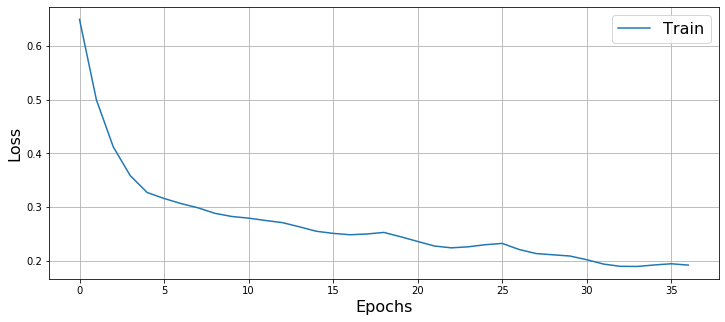

Epoch 37... (Train/Test) MSE: 0.181/0.181


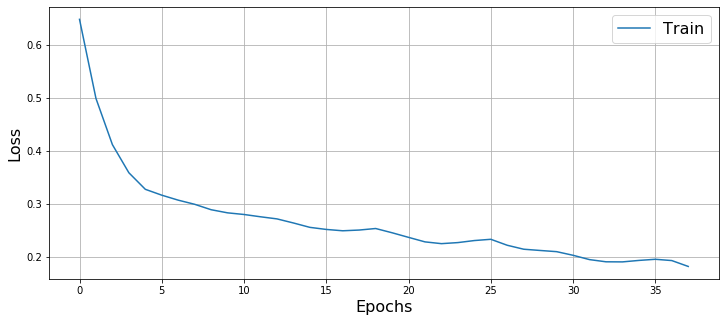

Epoch 38... (Train/Test) MSE: 0.174/0.174


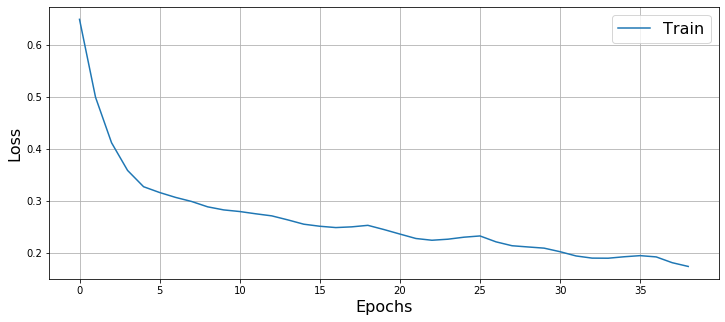

Epoch 39... (Train/Test) MSE: 0.170/0.170


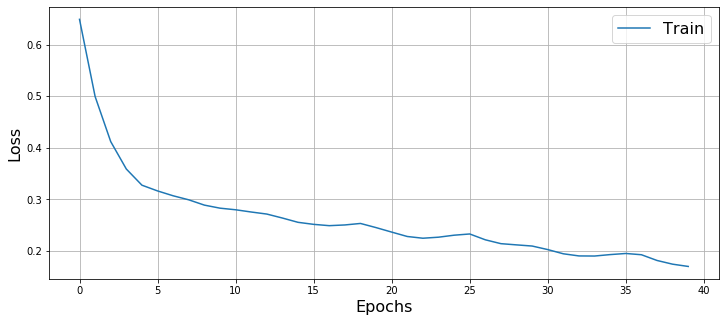

Epoch 40... (Train/Test) MSE: 0.171/0.171


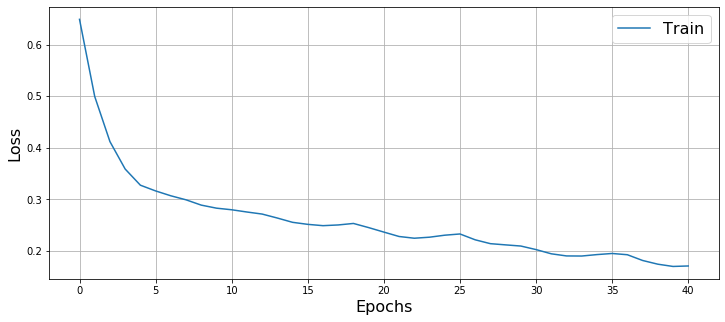

Epoch 41... (Train/Test) MSE: 0.168/0.168


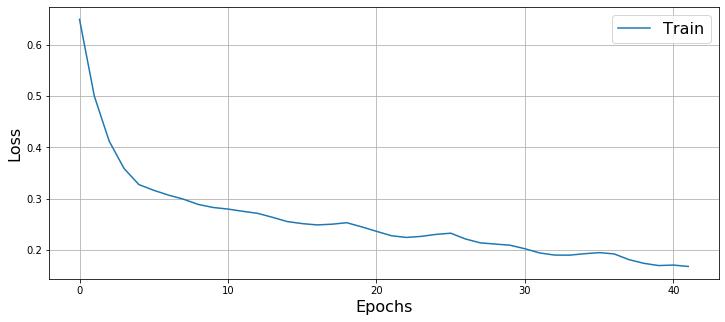

Epoch 42... (Train/Test) MSE: 0.164/0.164


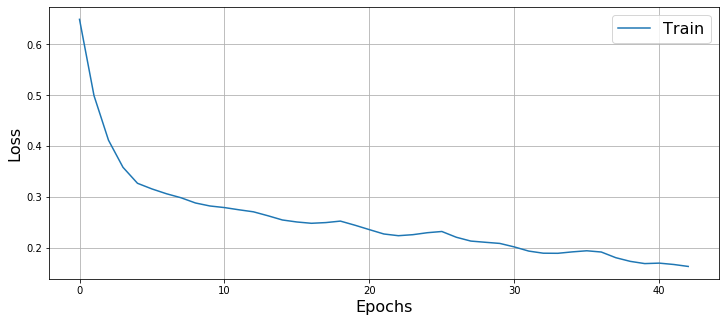

Epoch 43... (Train/Test) MSE: 0.160/0.160


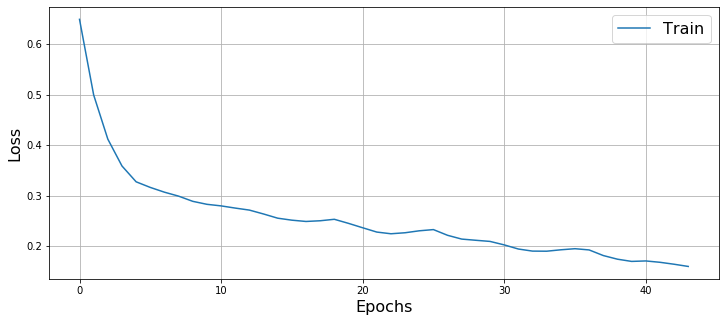

Epoch 44... (Train/Test) MSE: 0.157/0.157


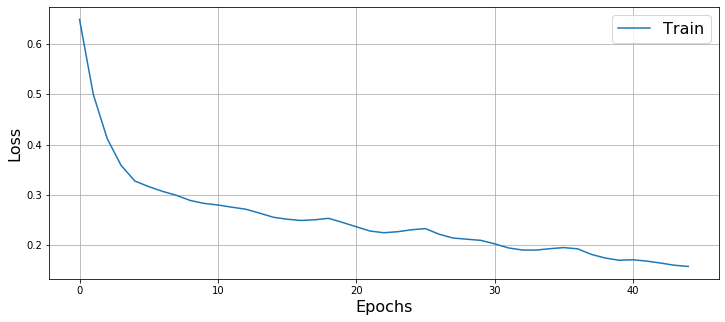

Epoch 45... (Train/Test) MSE: 0.157/0.157


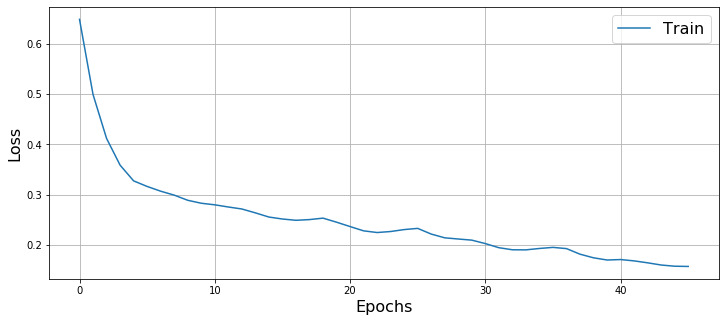

Epoch 46... (Train/Test) MSE: 0.159/0.159


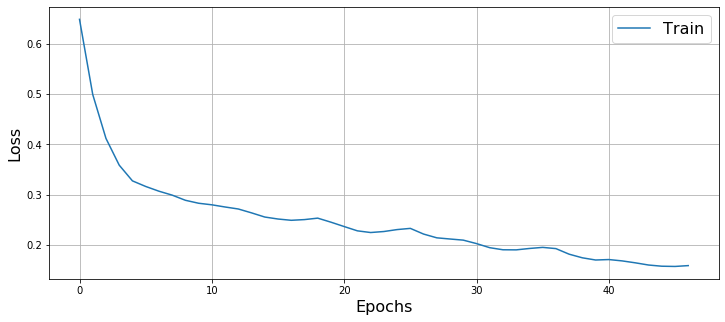

Epoch 47... (Train/Test) MSE: 0.155/0.155


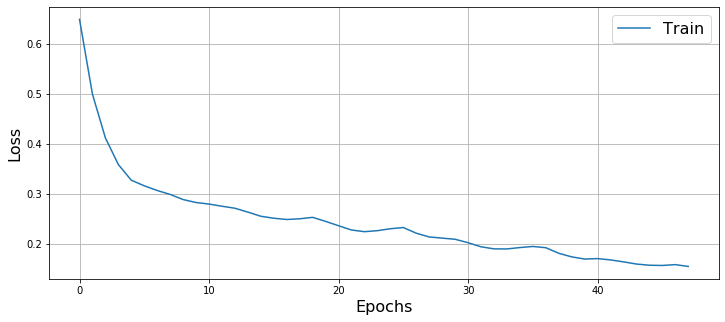

Epoch 48... (Train/Test) MSE: 0.155/0.155


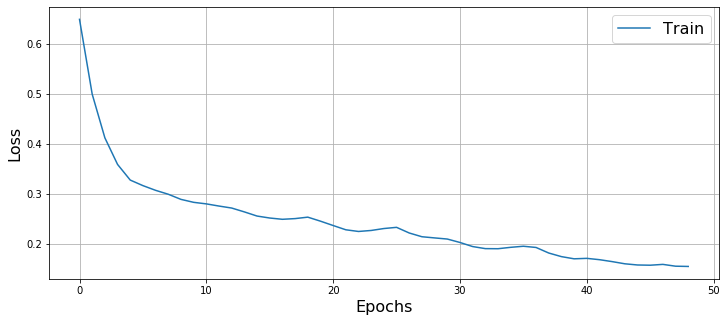

Epoch 49... (Train/Test) MSE: 0.148/0.148


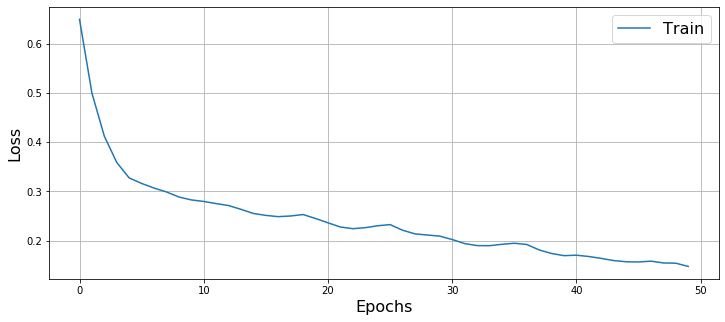

Epoch 50... (Train/Test) MSE: 0.145/0.145


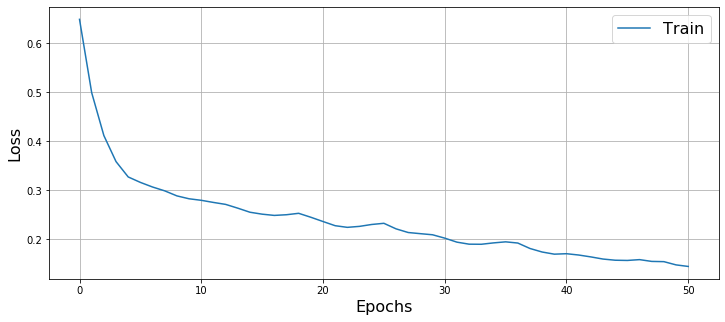

Epoch 51... (Train/Test) MSE: 0.148/0.148


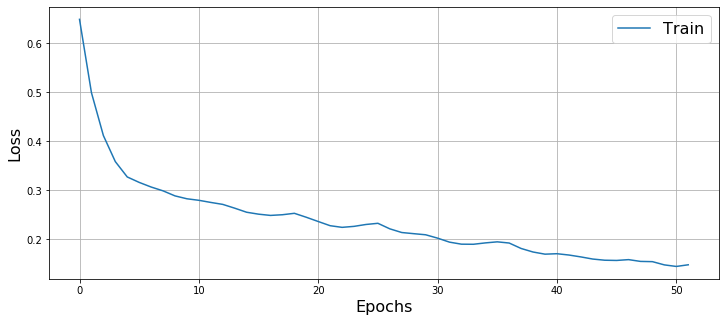

Epoch 52... (Train/Test) MSE: 0.149/0.149


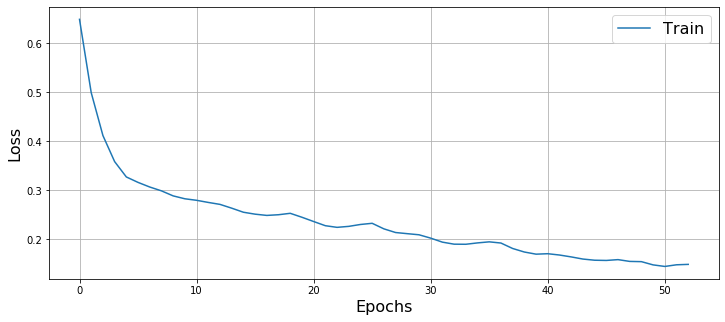

Epoch 53... (Train/Test) MSE: 0.144/0.144


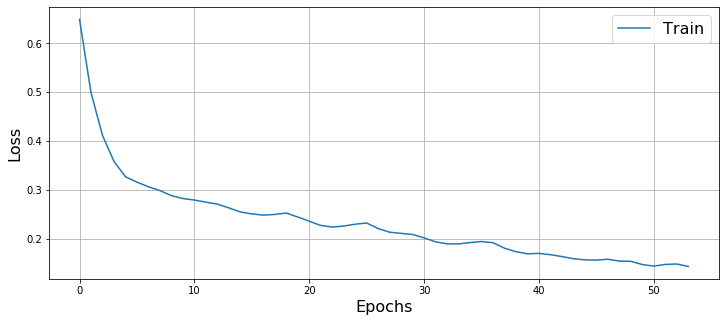

Epoch 54... (Train/Test) MSE: 0.145/0.145


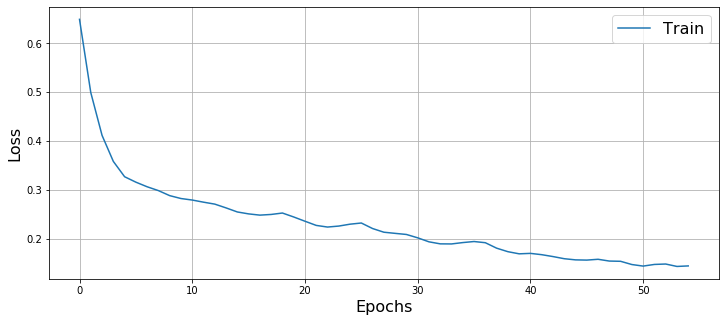

Epoch 55... (Train/Test) MSE: 0.142/0.142


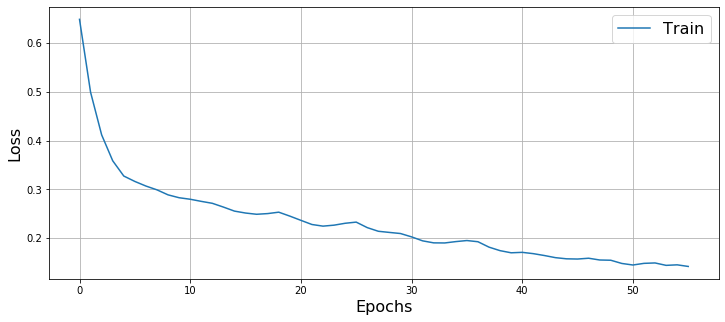

Epoch 56... (Train/Test) MSE: 0.141/0.141


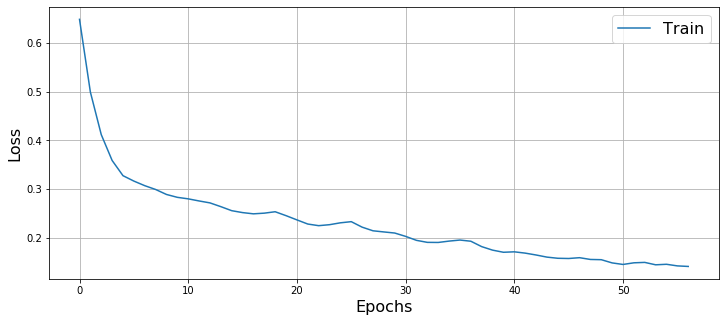

Epoch 57... (Train/Test) MSE: 0.138/0.138


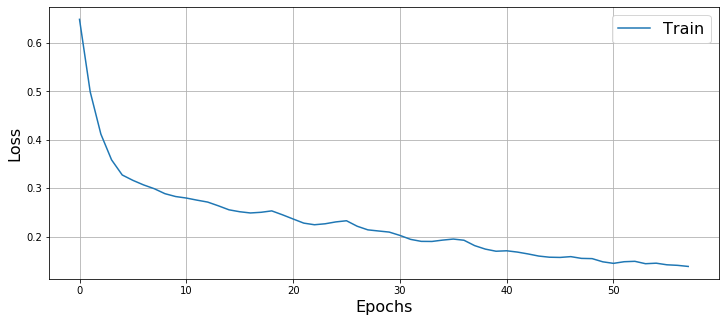

Epoch 58... (Train/Test) MSE: 0.139/0.139


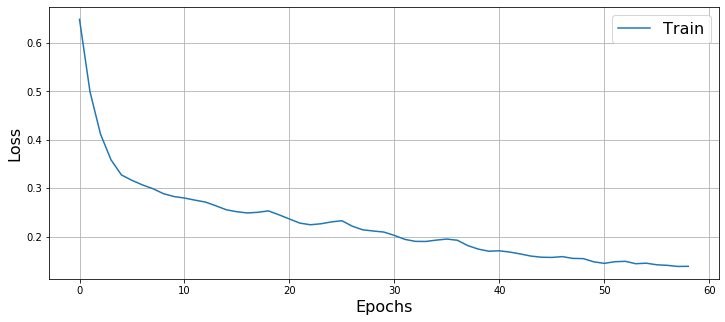

Epoch 59... (Train/Test) MSE: 0.138/0.138


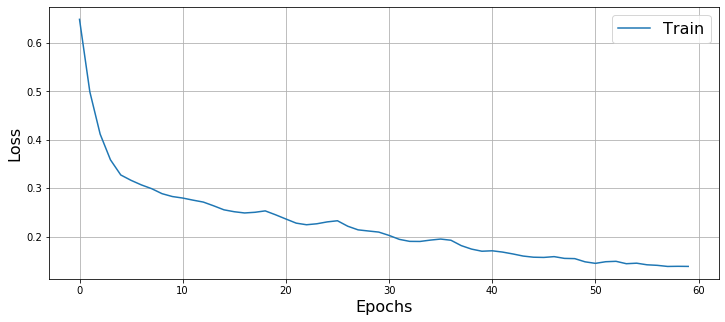

Epoch 60... (Train/Test) MSE: 0.136/0.136


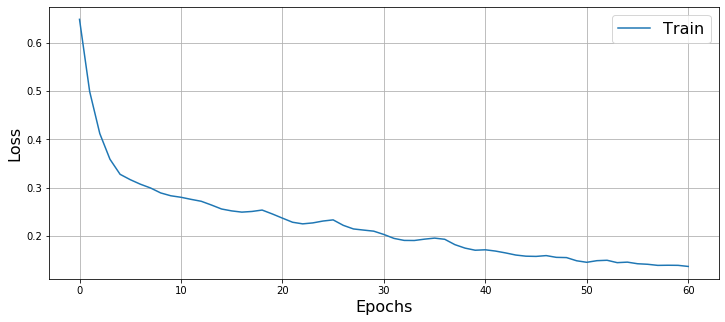

Epoch 61... (Train/Test) MSE: 0.135/0.135


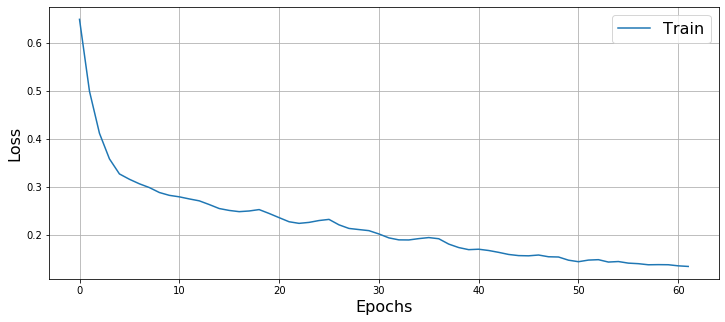

Epoch 62... (Train/Test) MSE: 0.132/0.132


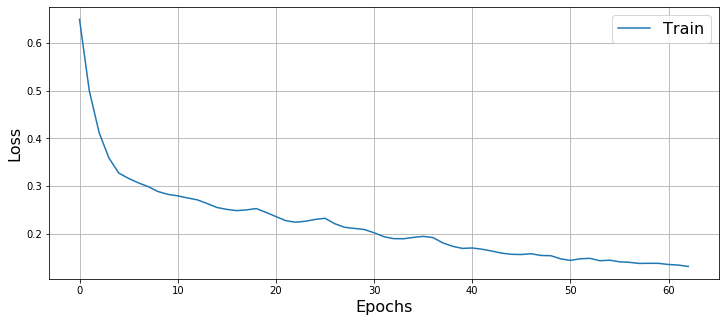

Epoch 63... (Train/Test) MSE: 0.130/0.130


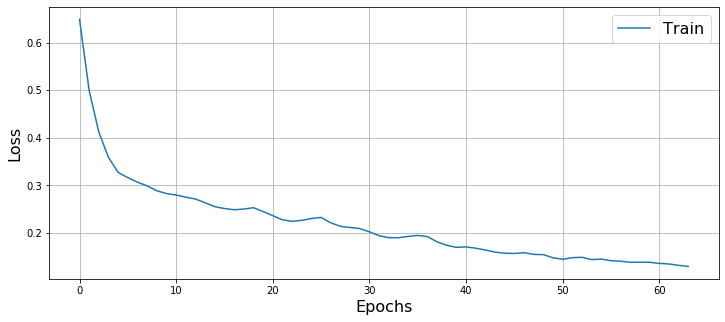

Epoch 64... (Train/Test) MSE: 0.123/0.123


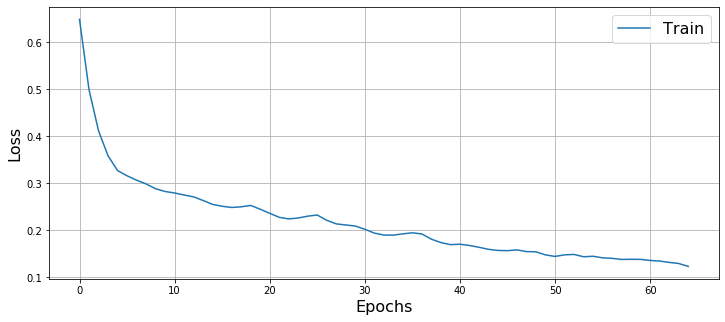

Epoch 65... (Train/Test) MSE: 0.117/0.117


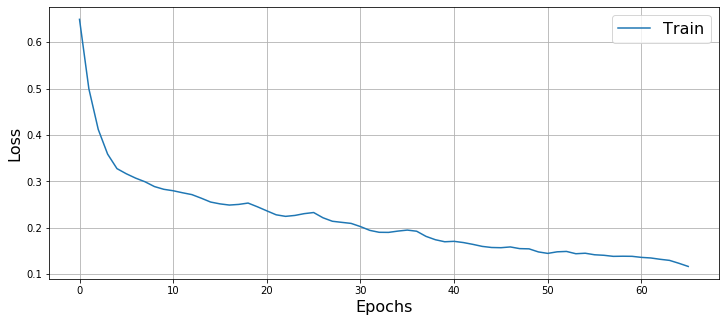

Epoch 66... (Train/Test) MSE: 0.112/0.112


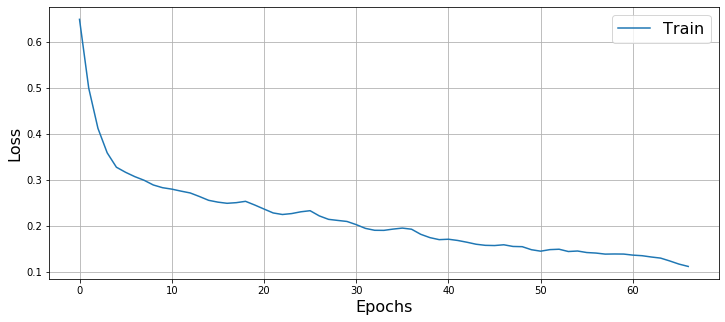

Epoch 67... (Train/Test) MSE: 0.109/0.109


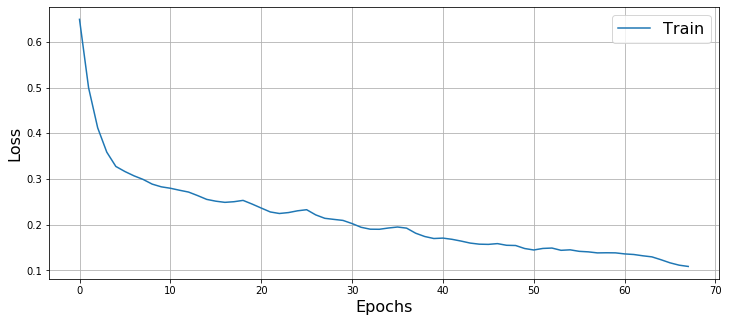

Epoch 68... (Train/Test) MSE: 0.105/0.105


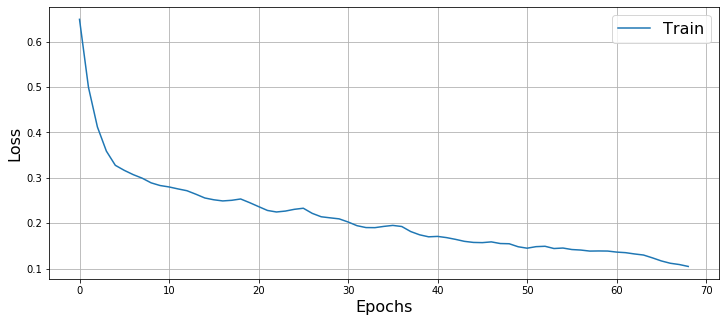

Epoch 69... (Train/Test) MSE: 0.103/0.103


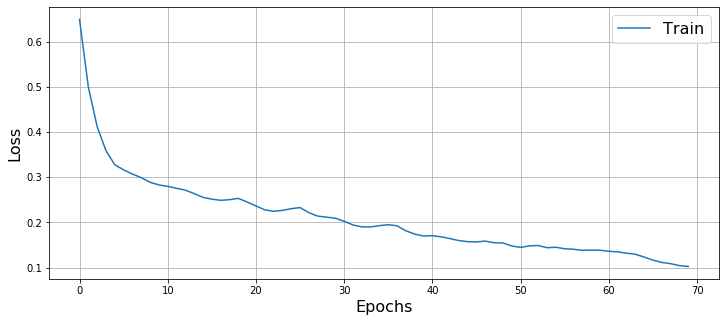

Epoch 70... (Train/Test) MSE: 0.102/0.102


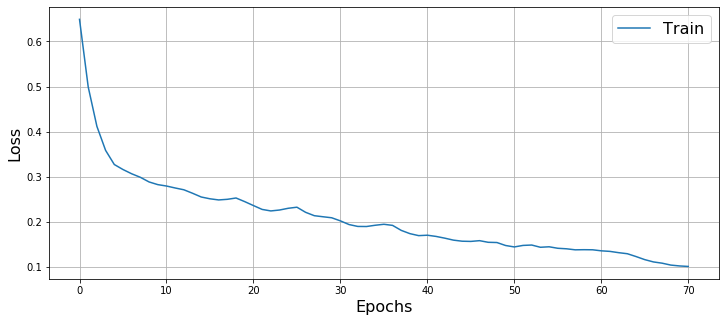

Epoch 71... (Train/Test) MSE: 0.099/0.099


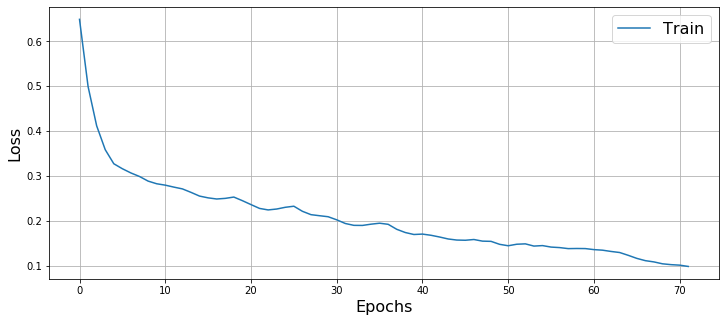

Epoch 72... (Train/Test) MSE: 0.098/0.098


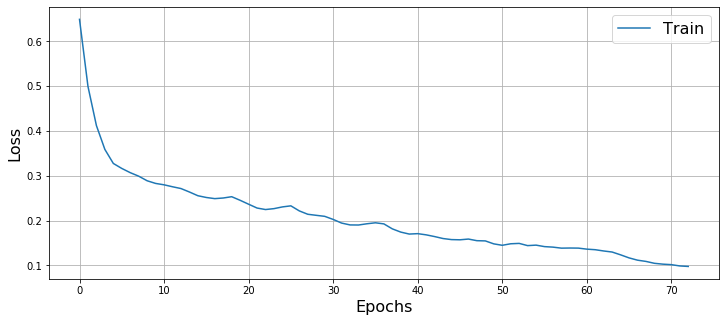

Epoch 73... (Train/Test) MSE: 0.095/0.095


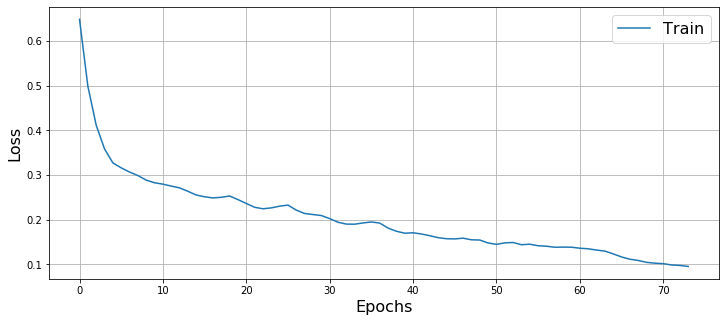

Epoch 74... (Train/Test) MSE: 0.093/0.093


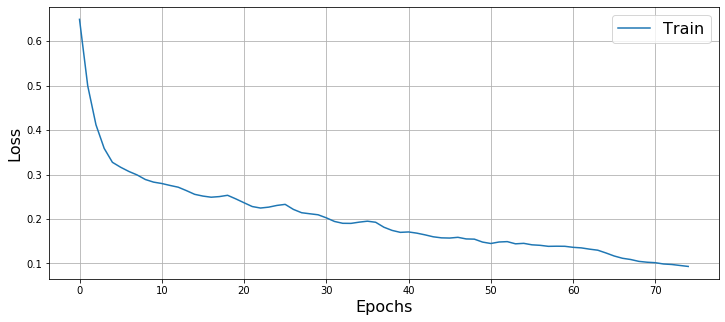

Epoch 75... (Train/Test) MSE: 0.091/0.091


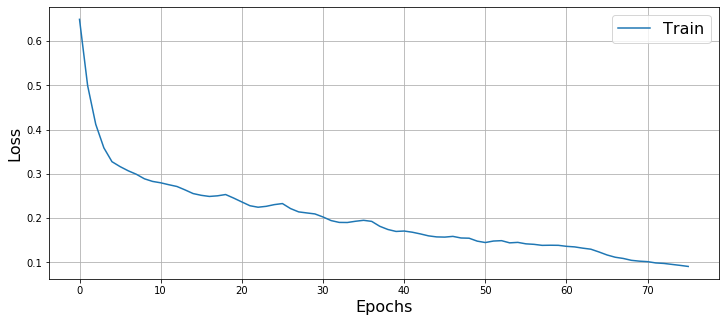

Epoch 76... (Train/Test) MSE: 0.089/0.089


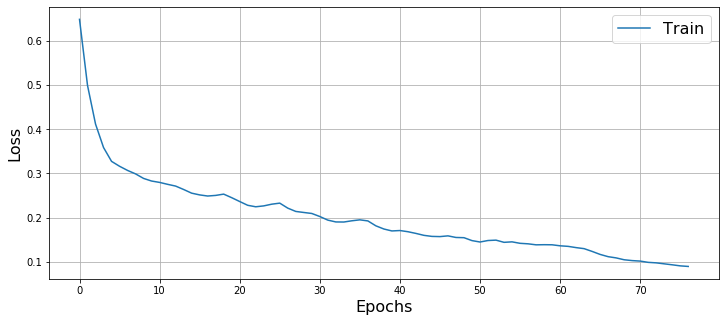

Epoch 77... (Train/Test) MSE: 0.088/0.088


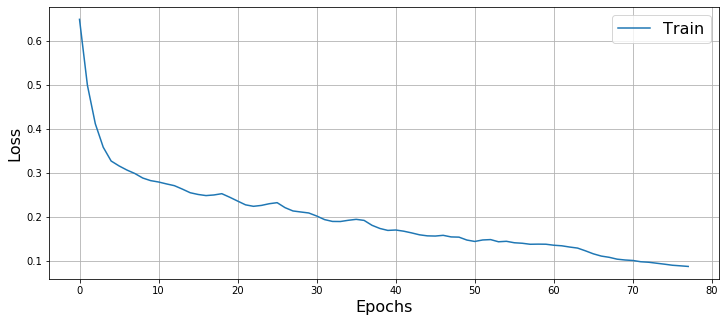

Epoch 78... (Train/Test) MSE: 0.087/0.087


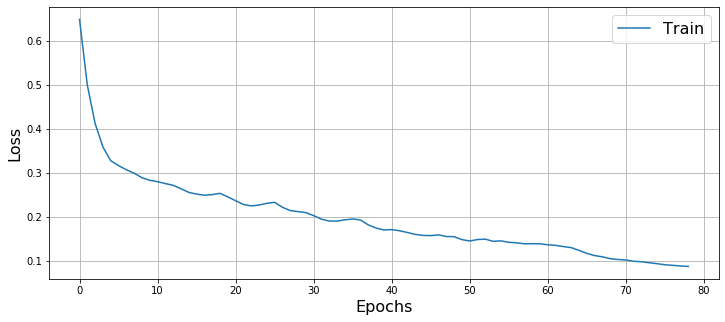

Epoch 79... (Train/Test) MSE: 0.086/0.086


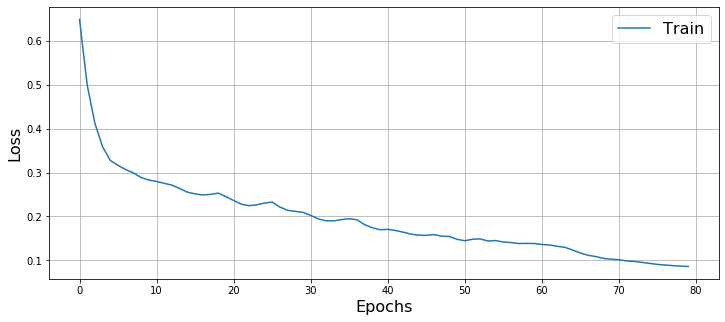

Epoch 80... (Train/Test) MSE: 0.086/0.086


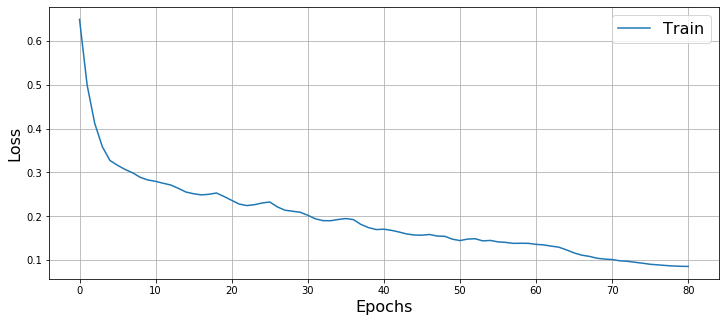

Epoch 81... (Train/Test) MSE: 0.086/0.086


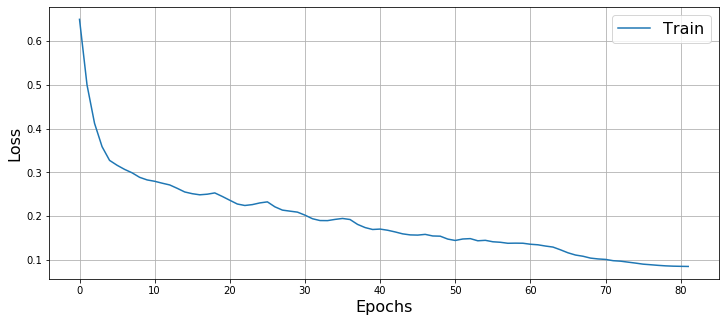

Epoch 82... (Train/Test) MSE: 0.085/0.085


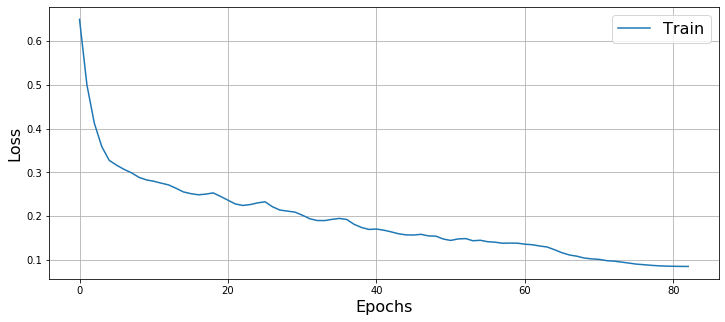

Epoch 83... (Train/Test) MSE: 0.085/0.085


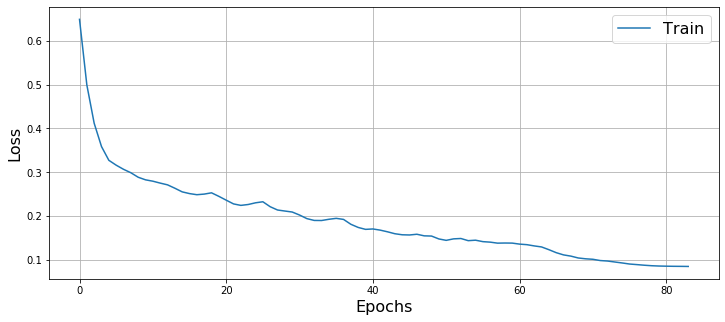

Epoch 84... (Train/Test) MSE: 0.085/0.085


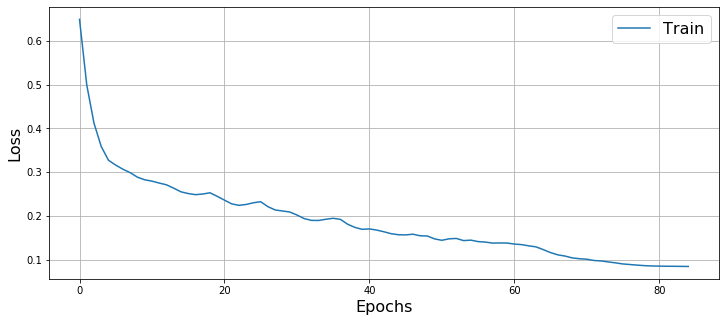

Epoch 85... (Train/Test) MSE: 0.085/0.085


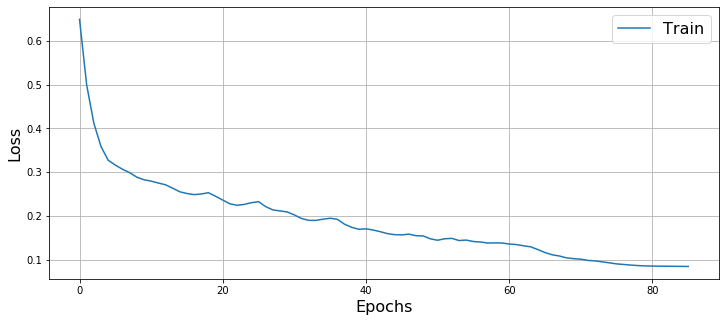

Epoch 86... (Train/Test) MSE: 0.085/0.085


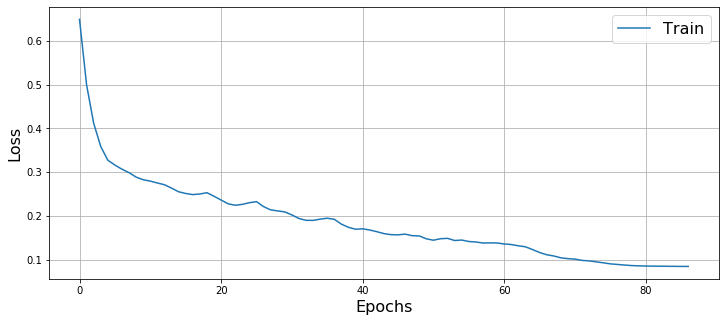

Epoch 87... (Train/Test) MSE: 0.085/0.085


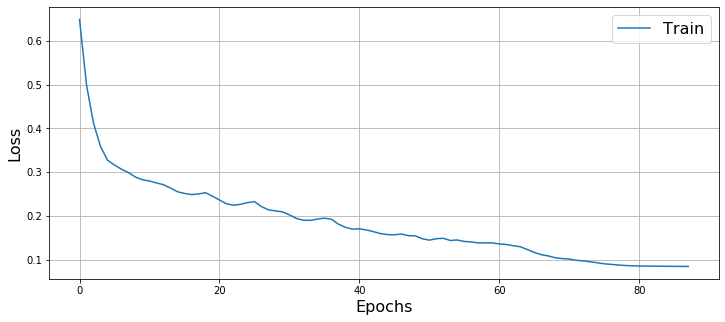

Epoch 88... (Train/Test) MSE: 0.085/0.085


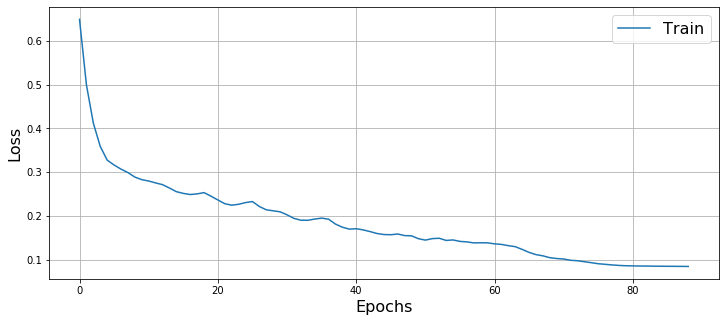

Epoch 89... (Train/Test) MSE: 0.085/0.085


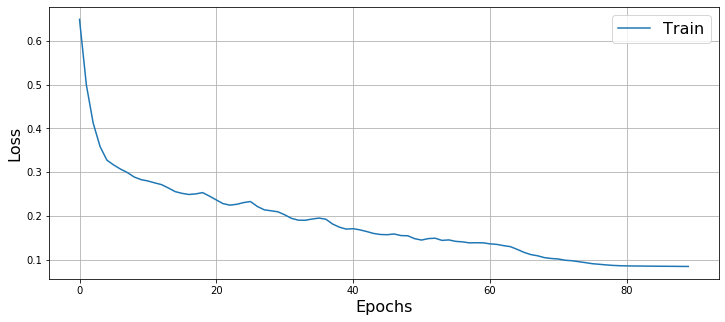

Epoch 90... (Train/Test) MSE: 0.084/0.084


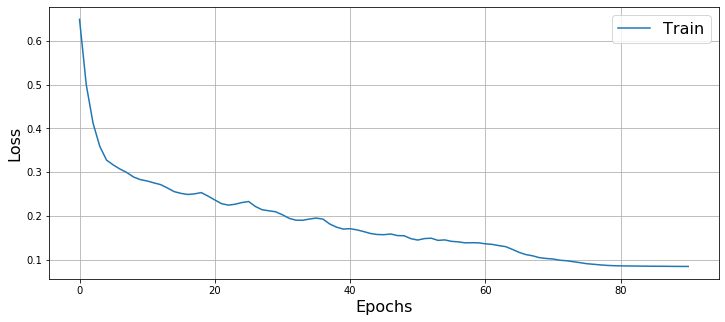

Epoch 91... (Train/Test) MSE: 0.084/0.084


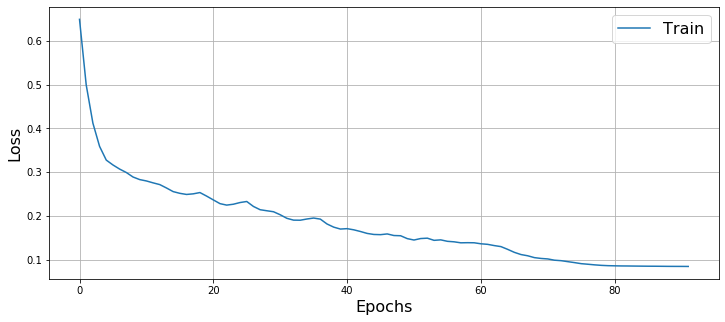

Epoch 92... (Train/Test) MSE: 0.084/0.084


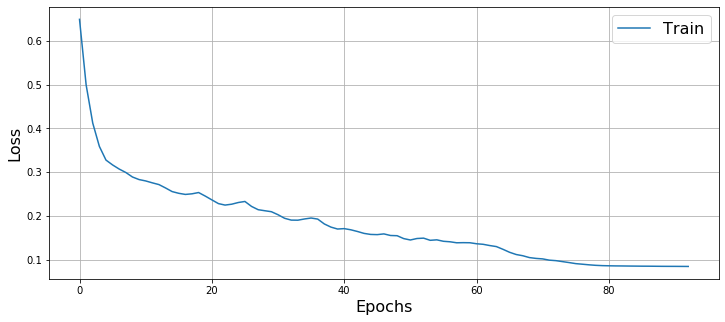

Epoch 93... (Train/Test) MSE: 0.084/0.084


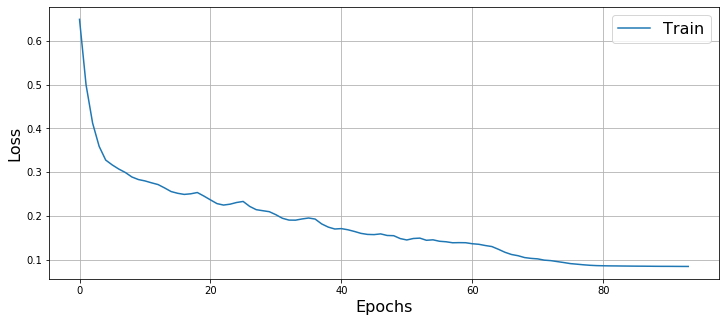

Epoch 94... (Train/Test) MSE: 0.084/0.084


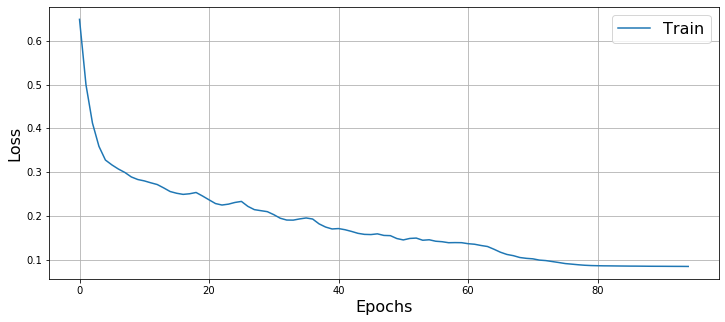

Epoch 95... (Train/Test) MSE: 0.084/0.084


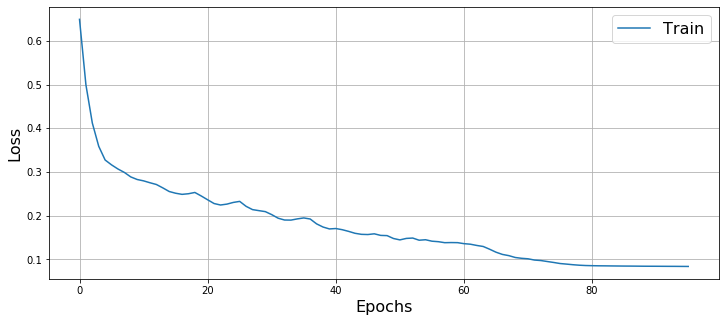

Epoch 96... (Train/Test) MSE: 0.084/0.084


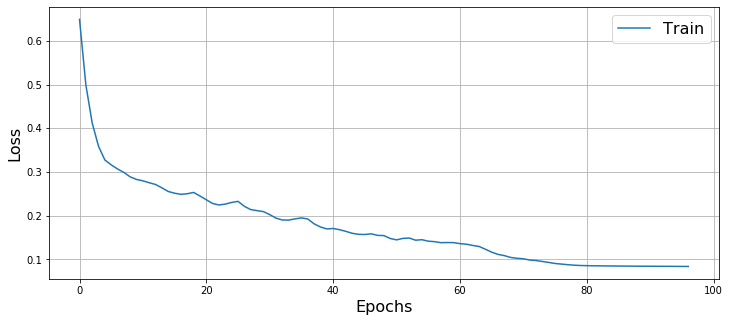

Epoch 97... (Train/Test) MSE: 0.084/0.084


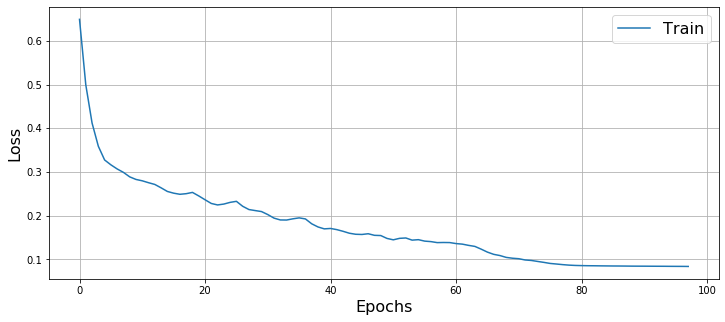

Epoch 98... (Train/Test) MSE: 0.084/0.084


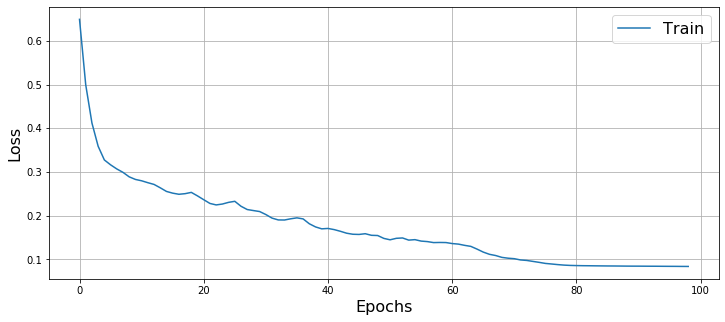

Epoch 99... (Train/Test) MSE: 0.084/0.084


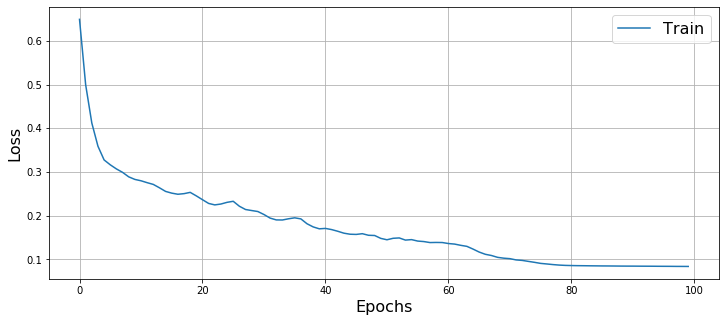

CPU times: user 43min 50s, sys: 5min 13s, total: 49min 4s
Wall time: 45min 55s


In [12]:
NET=UNet(n_channels=3)
%time train(NET, 100, 0.001)

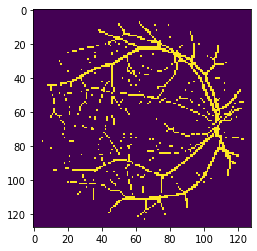

In [28]:
plt.imshow(train_dataset[12][1].detach().numpy()[0])

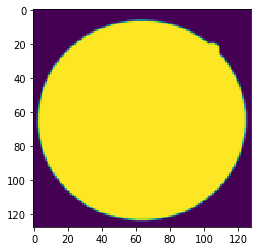

In [14]:
plt.imshow(filt.detach().numpy()[0])

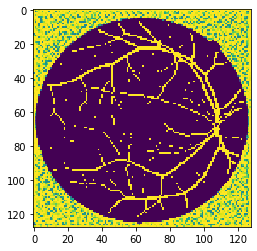

In [15]:
otv=NET(train_dataset[12][0].reshape(-1,3,128,128))
plt.imshow(otv[0].detach().numpy()[0])

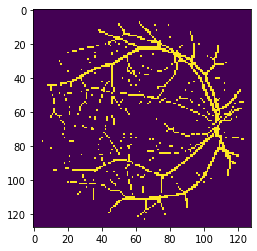

In [16]:
plt.imshow(train_dataset[12][1].detach().numpy()[0])

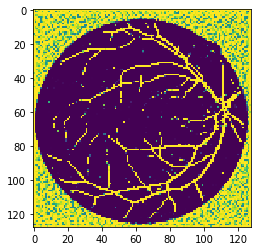

In [21]:
otv=NET(test_dataset[12].reshape(-1,3,128,128))
plt.imshow(otv[0].detach().numpy()[0])

In [30]:
#os.makedirs("result")

import imageio
model = NET.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype('uint8')*255
    
    imageio.imwrite("result/%s.png" % (ex_id + 1), tm)
    #scipy.misc.imsave("test/result/%s.png" % (ex_id + 1), tm)
    
!zip -r result.zip result

/Users/aleksandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


updating: result/ (stored 0%)
updating: result/8.png (stored 0%)
updating: result/9.png (stored 0%)
updating: result/14.png (stored 0%)
updating: result/15.png (stored 0%)
updating: result/17.png (stored 0%)
updating: result/16.png (stored 0%)
updating: result/12.png (stored 0%)
updating: result/13.png (stored 0%)
updating: result/11.png (stored 0%)
updating: result/10.png (stored 0%)
updating: result/20.png (stored 0%)
updating: result/18.png (stored 0%)
updating: result/19.png (stored 0%)
updating: result/4.png (stored 0%)
updating: result/5.png (stored 0%)
updating: result/7.png (stored 0%)
updating: result/6.png (stored 0%)
updating: result/2.png (stored 0%)
updating: result/3.png (stored 0%)
updating: result/1.png (stored 0%)


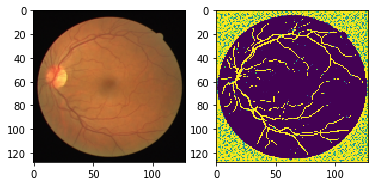

In [26]:
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)